<a href="https://colab.research.google.com/github/EdwinZhanCN/Projects-in-ML-and-AI/blob/main/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 1
### Objective Function
For logistic regression, we have:
$$
\hat{y} = σ(z) = \frac{1}{1+e^{-z}}
$$
where:
$$
z=w^Tx+b
$$
Establishing Burnoulli Likelihood:
$$
P(y|x) = \hat{y}^{y} (1-\hat{y})^{(1-y)}
$$
To find the likelihoo of whole dataset with m samples, we use product rule to multiply them together:
$$
L(\theta) = \prod_{i=1}^{m}P(y^{(i)}|x^{(i)})
$$
Apply natural logarithm and log rule for easier math:
$$
L(\theta)= \sum_{i=1}^{m} [y^{(i)}\log{(\hat{y}^{(i)})}+(1-y^{(i)})\log{(1-\hat{y}^{(i)})}]
$$
Take a negative to get the Loss Function:
$$
J(\theta) = - \sum_{i=1}^{m} [y^{(i)}\log{(\hat{y}^{(i)})}+(1-y^{(i)})\log{(1-\hat{y}^{(i)})}]
$$
### MAP vs MLE

The key difference is MAP has a extra Prior Probability Distribution over the mopdel parameters. In addition to MLE, MAP has a extra Regularization atcs as a penalty which prevent the features gaining large coefficient values.

#### Reference
[1] A. Genkin, D. D. Lewis, and D. Madigan, "Large-Scale Bayesian Logistic Regression for Text Categorization," Technometrics, vol. 49, no. 3, pp. 291-304, Aug. 2007.


### Problem use Logistic Regression

I'd like to investigate the breast cancer to predict whether a breast mass is Malignant or Benign based on digitalized measurement of FNA of the mass.

This problem is perfectly fits with logistic regression, we have tow distinct class for binary classification and unlike a hard classifier, logistic regression gives us a probability score which allows people to notice the threshold.

Comparing to SVM, which does not provide a probabilities output. And logistic regression consider all data points to maximize the likelihood whereas SVM does only consider points close to the margin to maximize the gap.

### Problem Mapping

- $x^{(i)}$, it is the input, and we should do cleanup on raw data to get the best, not closely related features.
- $y^{(i)}$, this is the diagnosis label, Malignant is 1, while Benign is 0, cause we're doing binary classification
- $\theta$, it is the weights will be learned by the model, each feature has its own weights.

To leverage to production rule, we should assume all patients in datasets are independent and indetically.

And there is no multicollinearity, we assume no such pair of features after cleanup should perfectly related.

## Task 2

### Breast Cancer Wisconsin (Diagnostic) Data Set

[Link to Kaggle](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data)

### EDA
#### Prepare Python Env

In [48]:
%pip install kagglehub pandas numpy seaborn matplotlib scikit-learn torch

#### Load dataset

In [49]:
import kagglehub
import pandas as pd
import numpy as np
import os

# Download latest version
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df=pd.read_csv(os.path.join(path, csv_file))
df_clean = df.drop(columns=["id",'Unnamed: 32'], errors = 'ignore')
df_clean['diagnosis'] = df_clean['diagnosis'].map({'M': 1, 'B': 0})
display(df_clean.head(5))

Using Colab cache for faster access to the 'breast-cancer-wisconsin-data' dataset.


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### EDA

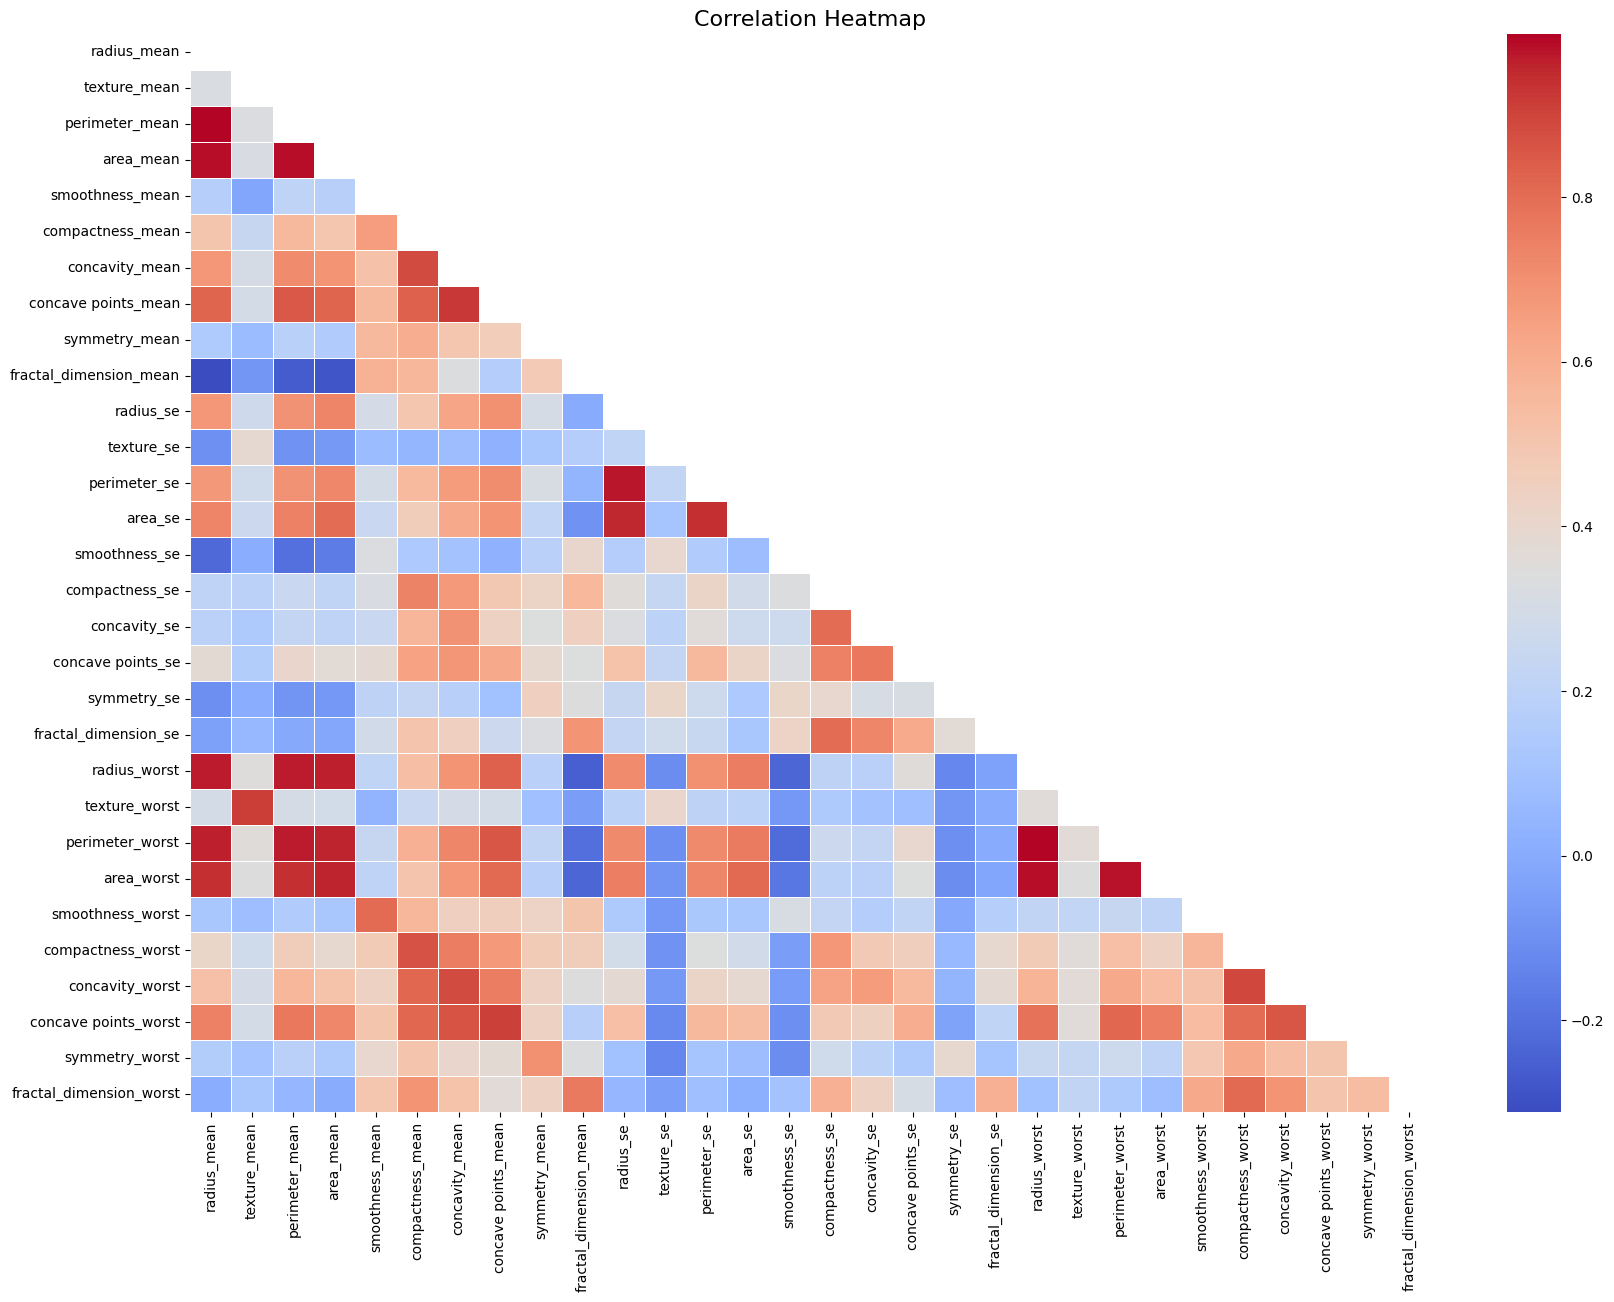

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 14))
corr_matrix = df_clean.drop(columns=['diagnosis']).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

#### VIF

In [51]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(input_df):
    X = add_constant(input_df)
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                       for i in range(X.shape[1])]
    vif_data = vif_data[vif_data["Feature"] != "const"]
    return vif_data.sort_values(by="VIF", ascending=False)

features = df_clean.drop(columns=['diagnosis'])
vif_all = calculate_vif(features)
print(vif_all.head(10))

# By heatmap shown above, we shall drop any perimeter mean and area mean (dark red).
features_new = features.drop(columns=[col for col in features.columns if 'perimeter' in col or 'area' in col])
vif_new = calculate_vif(features_new)
print(vif_new.head(10))

x_final = features_new.values
y_final = df_clean['diagnosis'].values

                Feature          VIF
1           radius_mean  3806.115296
3        perimeter_mean  3786.400419
21         radius_worst   799.105946
23      perimeter_worst   405.023336
4             area_mean   347.878657
24           area_worst   337.221924
11            radius_se    75.462027
7        concavity_mean    70.767720
13         perimeter_se    70.359695
8   concave points_mean    60.041733
                    Feature        VIF
5            concavity_mean  62.412701
6       concave points_mean  56.173416
17             radius_worst  41.856768
1               radius_mean  36.810455
20        compactness_worst  34.369937
22     concave points_worst  34.066341
21          concavity_worst  31.061220
4          compactness_mean  29.407348
24  fractal_dimension_worst  18.127464
18            texture_worst  17.918701


### Task 3
#### Logistic Regression

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 8:2 train:test
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.2, random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print(x_test.shape)
print(x_train.shape)

class LogisticRegression:
  def __init__(self, lr=0.001, epochs=1000):
    self.lr = lr
    self.epochs = epochs
    self.w = None
    self.b = None
    self.loss_history = []

  def sigmoid(self, z):
    z=np.clip(z, -250, 250)
    return 1/(1+np.exp(-z))

  def loss(self, y_true, y_pred):
    m=len(y_true)
    epsilon = 1e-9

    loss = (-1/m) * np.sum(y_true * np.log(y_pred +epsilon)+(1-y_true)*np.log(1-y_pred+epsilon))
    return loss

  def fit(self, x, y,mode='batch'):
    m, n = x.shape
    self.w=np.zeros(n)
    self.b=0
    self.loss_history = []

    for e in range (self.epochs):
      if mode == 'batch' :
        self._update_weights(x,y)

      elif mode == 'sgd':
        indices = np.random.permutation(m)
        for i in indices:
          x_i = x[i].reshape(1,-1)
          y_i = y[i].reshape(1)
          self._update_weights(x_i, y_i)
      elif mode == 'mini_batch':
        indices = np.random.permutation(m)
        x_shuffled = x[indices]
        y_shuffled = y[indices]
        batch_size = 32
        for i in range(0, m, batch_size):
          x_batch = x_shuffled[i:i+batch_size]
          y_batch = y_shuffled[i:i+batch_size]
          self._update_weights(x_batch, y_batch)

      if e % 10 == 0:
        model = np.dot(x, self.w) + self.b
        y_pred = self.sigmoid(model)
        loss = self.loss(y, y_pred)
        self.loss_history.append(loss)

  def _update_weights(self, x, y):
    m, n = x.shape
    model = np.dot(x, self.w) + self.b
    y_pred = self.sigmoid(model)
    dw = (1/m) * np.dot(x.T, (y_pred - y))
    db =(1/m) * np.sum(y_pred - y)
    self.w -= self.lr * dw
    self.b -= self.lr * db

  def predict(self, x):
    model = np.dot(x, self.w) + self.b
    y_pred = self.sigmoid(model)
    return np.round(y_pred)

(114, 24)
(455, 24)


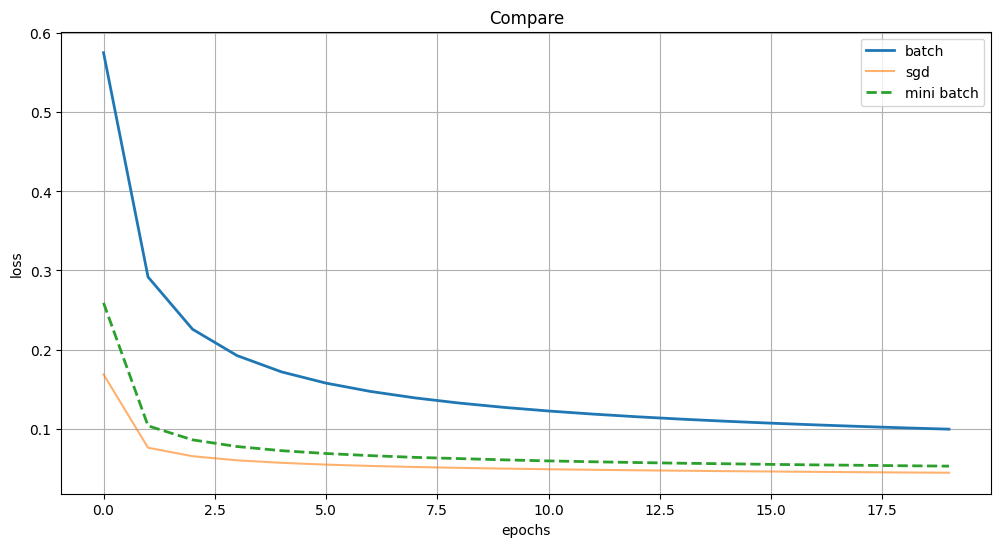

In [53]:
import matplotlib.pyplot as plt

model_batch = LogisticRegression(lr=0.1, epochs=200)
model_sgd = LogisticRegression(lr=0.01, epochs=200)
model_mini = LogisticRegression(lr=0.1, epochs=200)

model_batch.fit(x_train, y_train, mode='batch')
model_sgd.fit(x_train, y_train, mode='sgd')
model_mini.fit(x_train, y_train, mode='mini_batch')

plt.figure(figsize=(12, 6))
plt.plot(model_batch.loss_history, label='batch', linewidth=2)
plt.plot(model_sgd.loss_history, label='sgd', alpha=0.6)
plt.plot(model_mini.loss_history, label='mini batch', linewidth=2, linestyle='--')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Compare")
plt.legend()
plt.grid(True)
plt.show()

#### Explanation
I implement a custom class, which could reuse most of functions in a instance. for fit method, which allows consumer to use different mode of GD, so we can measure the difference seperately.

As the plot show above
- Batch mode has a relativelt smooth and steady curve downwards, but it converges very slow, as the formula shows, it takes care of all m samples in dataset and calculate the average, which leads to slow but accurate calculation.
- SGD has a super fast convergence, almost stabl at 2.5 epochs, but we can see at the interval 5.0 and 7.5, there is a small zig-zag where the loss act like up and down.
- Mini batch mode use subset of all samples to calculate the average, it stays in the middle, with a good convergence speed and smooth loss curve.

## Task 4
### Optimizer for SGD using PyTorch

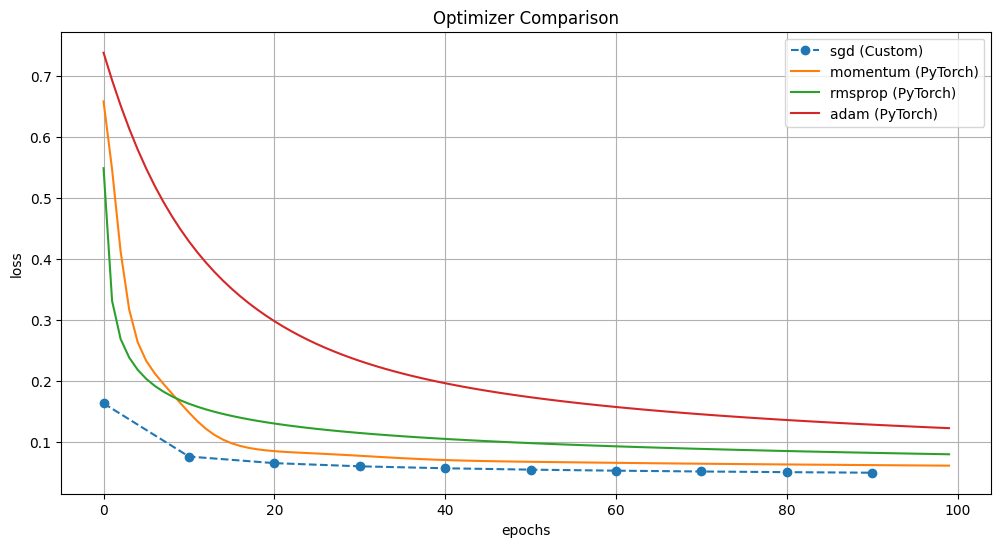

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Prepare Tensors for PyTorch
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

class LogisticRegressionTorch(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    def predict(self, x):
        # Helper to predict on numpy arrays
        x_tensor = torch.tensor(x, dtype=torch.float32)
        with torch.no_grad():
            return torch.round(self.forward(x_tensor)).numpy()

def train_with_optimizer(optimizer_name, learning_rate, epochs=100):
    model = LogisticRegressionTorch(x_train.shape[1])
    criterion = nn.BCELoss()

    if optimizer_name == 'momentum':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    for epoch in range(epochs):
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())

    return loss_history, model

plt.figure(figsize=(12, 6))

# 1. Custom SGD
model_custom_sgd = LogisticRegression(lr=0.01, epochs=100)
model_custom_sgd.fit(x_train, y_train, mode='sgd')

x_axis_custom = range(0, 100, 10)
plt.plot(x_axis_custom, model_custom_sgd.loss_history, label='sgd (Custom)', linestyle='--', marker='o')

# 2. PyTorch Optimizers
optimizers_list = ['momentum', 'rmsprop', 'adam']
trained_models = {}

for opt_name in optimizers_list:
    lr = 0.01 if opt_name in ['adam', 'rmsprop'] else 0.1
    losses, model = train_with_optimizer(opt_name, learning_rate=lr, epochs=100)
    trained_models[opt_name] = model
    plt.plot(losses, label=f'{opt_name} (PyTorch)')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Optimizer Comparison")
plt.legend()
plt.grid(True)
plt.show()

#### Eval

--- Report for SGD (Custom) ---
              precision    recall  f1-score   support

         (0)       0.99      0.97      0.98        71
         (1)       0.95      0.98      0.97        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

--- Report for Adam (PyTorch) ---
              precision    recall  f1-score   support

         (0)       0.97      0.97      0.97        71
         (1)       0.95      0.95      0.95        43

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



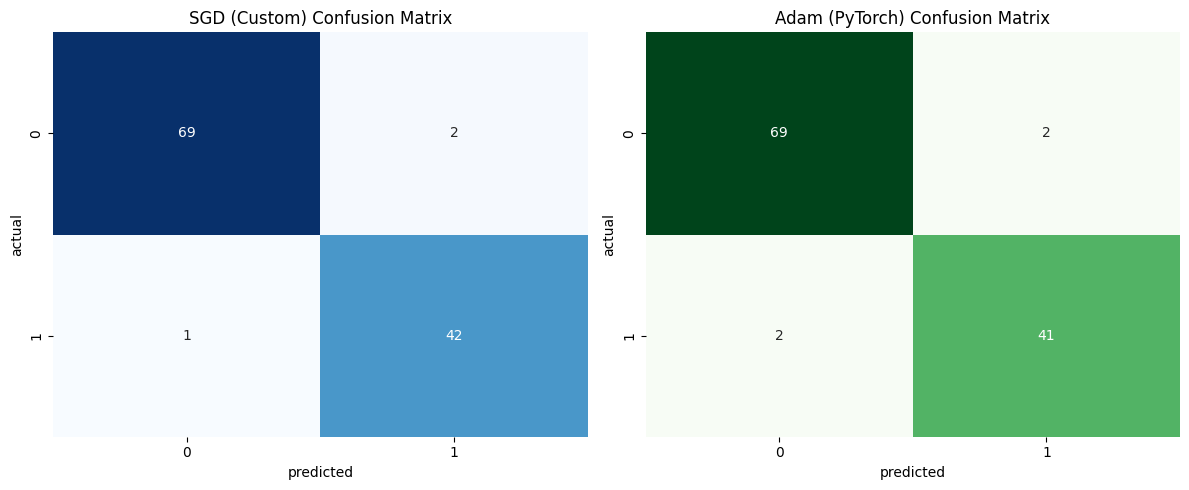

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def eval(model, x_test, y_test, model_name="Model"):
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)

    print(f"--- Report for {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=['(0)', '(1)']))

    return cm

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm_sgd = eval(model_custom_sgd, x_test, y_test, "SGD (Custom)")
sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("SGD (Custom) Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("actual")

plt.subplot(1, 2, 2)
cm_adam = eval(trained_models['adam'], x_test, y_test, "Adam (PyTorch)")
sns.heatmap(cm_adam, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Adam (PyTorch) Confusion Matrix")
plt.xlabel("predicted")
plt.ylabel("actual")

plt.tight_layout()
plt.show()

#### Hyperparameter Tuningh

In [56]:
from sklearn.metrics import accuracy_score, f1_score
import torch.optim as optim
import torch.nn as nn
import torch

lrs = [0.1, 0.01, 0.001]
betas = [0.9, 0.99]
results = []

print(f"{'lr':<10} {'beta1':<10} {'acc':<10} {'f1':<10}")
print("-" * 45)

best_f1 = 0
best_params = {}

for lr in lrs:
    for beta in betas:
        model = LogisticRegressionTorch(n_features=x_train.shape[1])

        optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta, 0.999))
        criterion = nn.BCELoss()

        epochs = 100
        for _ in range(epochs):
            outputs = model(x_train_tensor)
            loss = criterion(outputs, y_train_tensor)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # eval
        y_pred = model.predict(x_test)
        f1 = f1_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        print(f"{lr:<10} {beta:<10} {acc:.4f}     {f1:.4f}")

        # save best
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'lr': lr, 'beta': beta}


lr         beta1      acc        f1        
---------------------------------------------
0.1        0.9        0.9737     0.9655
0.1        0.99       0.9649     0.9545
0.01       0.9        0.9737     0.9655
0.01       0.99       0.9649     0.9545
0.001      0.9        0.7719     0.6829
0.001      0.99       0.9298     0.9111


report:
1. high lr like 0.1, with Adam cause oscillations, slightly lower in f1.
2. low lr 0.001 for example, might not converge fully in 100 epochs(0.91 and 0.90 in accuracy).
3. Tuning with Beta1 has less impact than lr.

### Conclusion
- Batch GD has a perfect loss curve, but the heighest complexity, $O(m*n)$, which requires high RAM usage, usually it has a fast convergence, but in this small dataset, lucky is the key for GD.

  For larger datasets, it may performs better than SGD in convergence, but it still consume a lot of RAM during training, so it is not suitable for most of large-scaled datasets.
- SGD has the noise and zig-zag pattern in loss curve, since our dataset is small, a random picked data point leads a better chance to converge well.

  And it uses the lowest RAM and lowest complexity, it exceptionally behaves well in samll dataset, but in large dataset, mathmatially it has lower chance to get a good convergence by calculating at a single random picked data point, so it will be slower than batch and mini-batch algorithm overall. Not suitable for large-scaled datasets.
- Mini Batch GD has a moderate convergence speed as expected, it is suitable for large-scaled datasets because of the balance in memory usage and convergence speed.

- Adam Optimized SGD is a perfect integration of Momentum and RMSProp, it has single learning rate for every weight, and use momentum to prevent the noise and zig-zag loss curve due to the speed variable. Which is ideal for all larg-scaled datasets training.